# Goodreads Book Reviews

In [36]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [40]:
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [41]:
#importing packages
import tqdm
import re
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import pickle

In [8]:
#dataset link

In [9]:
#set directory for loading dataset
DIR = './goodreads-master/'

In [10]:
#function to preview or read in the data the data
#takes each line to a list and then appends to a list to make a list of lists
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            data_list = []
            data_list.append(d['user_id'])
            data_list.append(d['book_id'])
            data_list.append(d['review_id'])
            data_list.append(d['rating'])
            data_list.append(d['review_text'])
            if r'(view spoiler)' in d['review_text']:
                data_list.append(1)
            else: data_list.append(0)
            data.append(data_list)
            count += 1
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [11]:
#load in raw text (this will probably a little while)
data = load_data(os.path.join(DIR, 'goodreads_reviews_spoiler_raw.json.gz'), head = None)

In [12]:
#take the list of lists to DF

df = pd.DataFrame(data, columns = ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'spoiler'])
print(df.review_id.nunique())

df.set_index('review_id', inplace = True)
print('')
df.info()


1378033

<class 'pandas.core.frame.DataFrame'>
Index: 1378033 entries, dfdbb7b0eb5a7e4c26d59a937e2e5feb to 62ed1263c7d216986cc419cd4e8a408b
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1378033 non-null  object
 1   book_id      1378033 non-null  object
 2   rating       1378033 non-null  int64 
 3   review_text  1378033 non-null  object
 4   spoiler      1378033 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 63.1+ MB


In [13]:
#remove data from memory
del(data)

## Early Data Exploration

In [39]:
df.rating.value_counts()

4    480199
5    403374
3    290430
2    112226
0     47052
1     44752
Name: rating, dtype: int64

I was not expecting the 0 score for reviews. Let's take a look.

**Not necessary to rerun**

In [40]:
#list of 0 scored reviews
review_text0 = [df.review_text.iloc[i] for i in range(len(df.review_text)) if df.rating.iloc[i] == 0]

In [41]:
#random sample to examine data
np.random.choice(review_text0)

"Okay, this book has disrupted my gym time for long enough. The good part: for the past month, I've been reading scientific papers to avoid reading this book. The bad part: I've been procrastinating about going to the gym to avoid both. \n No more. \n I'm pausing this book--not necessarily DNF'ing: I've made it about 80% through and that's just too far to give up. There's nothing wrong with it; it's just not for me. \n However, if you like Fated or Something from the Nightside, this may very well be a good fit--definitely worth a try, at any rate. \n I was going to do an amazon-style audience recommendations in lieu of a review, but it kind of devolved into a network of how I think the UF world fits together, and a network is extremely appropriate given the subject of the book. \n Link to big version \n I know the format's messy, but don't look at me--I didn't write the fitting algorithm (it's graphviz)."

Reviews with 0 stars often appear to be from people who did not finish the book or were in the process of reading. However, they can also be legitimate reviews. They are sometimes negative or positive, but are most often neutral. Goodreads allows you to review without setting the stars, so these reviews should likely be thrown out for prediction purposes.

In [42]:
#remove from memory
del(review_text0)

## Data Cleaning

In [14]:
#removing the 0 ratings
df = df.loc[df.rating != 0]
len(df)

1330981

In [15]:
#remove those reviews of under 100 characters for computational speed purposes
df = df.loc[(df.review_text.astype(str).str.len()) >= 100]
len(df)

1175005

In [16]:
#number of unique users
df.user_id.nunique()

18833

In [17]:
#number of unique books
df.book_id.nunique()

25466

In [18]:
#mapping the 5 starts to negative, neutral, positive
df.rating = df.rating.map({1 : -1, 2 : -1, 3 : 0, 4 : 1, 5: 1})
df.rating.value_counts()

 1    771529
 0    261806
-1    141670
Name: rating, dtype: int64

In [19]:
#down sampling the largest class to make it the sum of the size of the other classes; doing this to help simpler models and to help with hardware constraints
df1 = df.loc[df.rating == 1].sample(n = 403476, random_state = 87, axis = 0)
len(df1)

403476

In [20]:
#append the downsampled positive reviews to the new dataframe
df = df.loc[df.rating != 1].append(df1)
len(df)

806952

In [21]:
#removing other df from memory
del(df1)

## Normalization and Preprocessing

In [21]:
#building out a normalization dict to perform prior to stemming
normalization_dict = {'was' : 'be', 'is' : 'be', 'are': 'be', 'been': 'be', 'were': 'be', 'am' : 'be', 
                      'wasnt':'isnt', 'arent':'isnt', 'werent':'isnt', 'does': 'do', 'has': 'have', 'had' : 'have',
                      'so':'', 'such':'', 'the':'', 'a':'', 'an':'', 'to': '', 'of':'', 'in':'', 'on':'', 'all':'', 
                      'for':'', 'about':'', 'at':'', 'that':'', 'this':'', 'probably':'', 'just':'', 'as':'',
                      '1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', #numbers 
                      'he':'_pron_', 'she':'_pron_', 'i':'_pron_', 'we':'_pron_', 'you':'_pron_', 'it':'_pron_', 'they':'_pron_', #personal subject pronouns
                      'me':'_pron_', 'us':'_pron_', 'her':'_pron_', 'him':'_pron_', 'them':'_pron_', 'his':'_pron_'} #obj pronouns

In [43]:
#writing a preprocessing and normalization function

from nltk.stem import PorterStemmer
 
# init stemmer
porter_stemmer=PorterStemmer()
 
def basic_preprocessor(text):
    text = re.sub(r"(view spoiler)|(hide spoiler)|\n", "", text) #removing view spoiler, hide spoiler and newline char
    
    text=text.lower() #lower case text
    
    text = re.sub("[^a-z0-9 ]+", "", text) #remove everything except letters and numbers, and spaces (can replace with blank)
    
    #split out words for our list comprehension
    words=re.split("\\s+",text)
    
    #use the normalization words
    normalization_words = [normalization_dict[word] if word in normalization_dict.keys() else word for word in words]
    
    # stem words that aren't blank
    stemmed_words=[porter_stemmer.stem(word=word) for word in normalization_words if word != ""]
        
    return ' '.join(stemmed_words)

**Be careful of processing time below. DO NOT RERUN**

In [24]:
#preprocessing text
df.review_text = [basic_preprocessor(text) for text in df.review_text]

In [45]:
#checking preprocessing
df.review_text[0]

'fun fast pace scienc fiction thriller _pron_ read _pron_ two night and couldnt put _pron_ down book be quantum theori mani world which state decis _pron_ make throughout our live basic creat branch and each possibl path through decis tree can be thought parallel world and book someon invent way switch between these world be nice allud toforeshadow quot _pron_ think choic weve made creat moment _pron_ sit here togeth beauti tabl then _pron_ think possibl event could have stop moment from ever happen and _pron_ feel _pron_ dont know what fragil now _pron_ becom thought moment _pron_ say final it terrifi when _pron_ consid everi thought _pron_ have everi choic _pron_ could possibl make branch into new world book cant be discuss without spoiler _pron_ be book choic and regret ever regret not chase girl your dream _pron_ can focu your career well jason2 made choic and then did regret _pron_ clearli author be tri tell _pron_ optim happi be second rate physic teacher commun colleg if _pron_ 

In [30]:
#pickling the preprocessed text
with open("preprocessed_text.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.review_text), fp)

## Splitting Data Prior to Feature Creation/Engineering

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['rating', 'user_id', 'book_id'], axis = 1), 
                                                    df.rating, test_size=0.20, random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(645561, 2) (645561,)
(161391, 2) (161391,)


In [20]:
#remove df from memory
del(df)

In [41]:
#pickling the split data
with open("y_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(y_train, fp)

In [22]:
#pickling the split data
with open("y_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(y_test, fp)

## CountVectorizer Feature Creation from Text

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df = 0.20, min_df = 400, ngram_range = (1,2), lowercase = False)

In [40]:
count_vectors_train = count_vectorizer.fit_transform(X_train.review_text)

In [41]:
count_vectors_test = count_vectorizer.transform(X_test.review_text)

In [42]:
len(count_vectorizer.vocabulary_)

34014

In [43]:
#pickling the results
with open("count_vectors_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(count_vectors_train, fp)

In [21]:
#unpickle the results
with open("count_vectors_train.pkl", "rb") as fp:   # Unpickling
    count_vectors_train = pickle.load(fp)

In [44]:
#pickling the results
with open("count_vectors_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(count_vectors_test, fp)

In [22]:
#unpickle the results
with open("count_vectors_test.pkl", "rb") as fp:   # Unpickling
    count_vectors_test = pickle.load(fp)

In [37]:
del(count_vectors_train, count_vectors_test)

## Tfidf Feature Creation from Text

In [38]:
#Count Vectorizer or tfidf_vectorizer?
#I use 20% because only using bigrams due to memory constraints (would use 25 - 30% if included 1-grams)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df = 0.20, min_df = 400, ngram_range = (1,2),
                                  lowercase = False)

In [39]:
tfidf_vectors_train = tfidf_vectorizer.fit_transform(X_train.review_text)

In [40]:
#pickling the results
with open("tfidf_vectors_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_train, fp)

In [6]:
#unpickle the results
with open("tfidf_vectors_train.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_train = pickle.load(fp)

In [41]:
tfidf_vectors_test = tfidf_vectorizer.transform(X_test.review_text)

In [42]:
#pickling the results
with open("tfidf_vectors_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_test, fp)

In [5]:
#unpickle the results
with open("tfidf_vectors_test.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_test = pickle.load(fp)

In [43]:
len(tfidf_vectorizer.vocabulary_)

34014

In [44]:
tfidf_vectors_train.shape

(645561, 34014)

In [45]:
#checking if some expected words are in our vocab to deterime if 20% is an OK cutoff for frequency
tfidf_vectorizer.vocabulary_['isnt _pron_']

17193

In [46]:
# print idf values
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).iloc[:15]

,idf_weights
happen,2.618200
with _pron_,2.619733
read _pron_,2.640512
review,2.652715
peopl,2.654350
bit,2.658547
thought,2.661651
have be,2.666133
plot,2.666838
felt,2.667413


In [47]:
feature_names = tfidf_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tfidf_vectors_train[0]
 
#print the scores
df1 = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False).head(15)

,tfidf
do take,0.183366
teen,0.182682
sure who,0.180712
feat,0.169914
loveh,0.165187
and experi,0.164603
adult,0.162848
book ill,0.162522
peer,0.162116
take time,0.162000


In [48]:
del(df1)

## Reducing Dimensionality of tfidf

In [49]:
#using truncated SVD to reduce dimensionality further
#truncated SVD can take sparse matricies which is important due to memory constraints
from sklearn.decomposition import TruncatedSVD

#sklearn recommends 100 components for LSA
svd = TruncatedSVD(n_components=300, n_iter=10, random_state=87)

**Be careful of calc time**

In [50]:
SVD_train = svd.fit_transform(X = tfidf_vectors_train)

In [51]:
#pickling the results
with open("SVD_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_train, fp)

In [5]:
#unpickle the results
with open("SVD_train.pkl", "rb") as fp:   # Unpickling
    SVD_train = pickle.load(fp)

In [52]:
SVD_test = svd.transform(X = tfidf_vectors_test)

In [53]:
#pickling the results
with open("SVD_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_test, fp)

In [6]:
#unpickle the results
with open("SVD_test.pkl", "rb") as fp:   # Unpickling
    SVD_test = pickle.load(fp)

In [54]:
type(SVD_train)

numpy.ndarray

In [55]:
SVD_train.shape

(645561, 300)

In [84]:
#keeping memory cleared out
del(X_train, X_test, tfidf_vectors_train, tfidf_vectors_test)

## Modeling Sentiment with Basic NLP Techniques

### Logistic Regression

#### Count Vectorizer Tuning

In [27]:
from sklearn.linear_model import LogisticRegressionCV
count_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 537)

In [28]:
count_logit_model = count_cv.fit(count_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 81.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 81.7min finished


In [29]:
count_logit_model.scores_

{-1: array([[0.67180946, 0.72278504, 0.73416733, 0.72403666, 0.71508325,
         0.71287123, 0.71280926, 0.71280307],
        [0.670878  , 0.72171758, 0.73331681, 0.72467935, 0.71664911,
         0.71493277, 0.71477787, 0.71477787],
        [0.67062395, 0.72096165, 0.73223868, 0.72286387, 0.71519921,
         0.71340232, 0.71328459, 0.713266  ],
        [0.67172687, 0.72386145, 0.73494021, 0.72476609, 0.71685358,
         0.71506909, 0.71478406, 0.71478406]]),
 0: array([[0.67180946, 0.72278504, 0.73416733, 0.72403666, 0.71508325,
         0.71287123, 0.71280926, 0.71280307],
        [0.670878  , 0.72171758, 0.73331681, 0.72467935, 0.71664911,
         0.71493277, 0.71477787, 0.71477787],
        [0.67062395, 0.72096165, 0.73223868, 0.72286387, 0.71519921,
         0.71340232, 0.71328459, 0.713266  ],
        [0.67172687, 0.72386145, 0.73494021, 0.72476609, 0.71685358,
         0.71506909, 0.71478406, 0.71478406]]),
 1: array([[0.67180946, 0.72278504, 0.73416733, 0.72403666, 0.7150832

Looks like C = 0.01 is the best

In [31]:
from sklearn.linear_model import LogisticRegression

count_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=357, C=0.01, penalty='l2', max_iter=500, n_jobs = -1)

In [32]:
#only using count vector features
model = count_log_reg.fit(count_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.5min finished


In [33]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
count_preds = model.predict(count_vectors_test)
# Probabilities for each class
count_probs = model.predict_proba(count_vectors_test)[:,]

count_accuracy_score = accuracy_score(y_test, count_preds)
count_f1_value = f1_score(y_test, count_preds, average ='weighted')
count_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(count_accuracy_score))
print("       F-score:     {:0.4f}".format(count_f1_value))
print("      Log Loss:     {:0.4f}".format(count_log_loss_value))

Accuracy Score:     0.7356
       F-score:     0.7300
      Log Loss:     0.6251


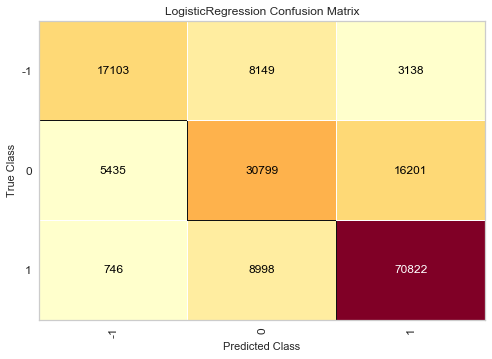

In [35]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(count_vectors_train, y_train)
knn_cm.score(count_vectors_test, y_test)

knn_cm.show()

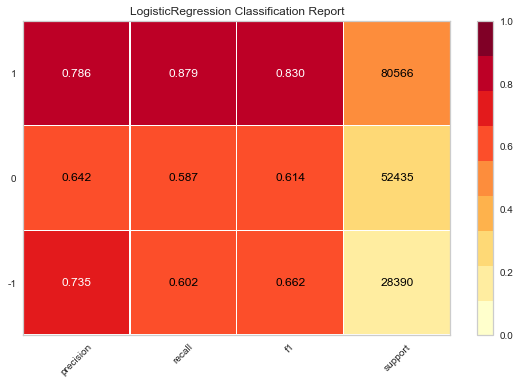

In [36]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(count_vectors_train, y_train)        # Fit the visualizer and the model
visualizer.score(count_vectors_test, y_test)        # Evaluate the model on the test data
visualizer.show()

#### Tfidf Features Tuning

In [56]:
from sklearn.linear_model import LogisticRegressionCV
tfidf_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=4, verbose=1, random_state = 53)

In [57]:
tfidf_logit_model = tfidf_cv.fit(tfidf_vectors_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 116.5min remaining: 116.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 117.3min finished


In [58]:
tfidf_logit_model.scores_

{-1: array([[0.50020137, 0.5094522 , 0.67535984, 0.73440898, 0.74058653,
         0.72795881, 0.72233892, 0.72087663],
        [0.50020447, 0.51006878, 0.67436025, 0.73341595, 0.73978561,
         0.72796951, 0.72176715, 0.7208749 ],
        [0.50019828, 0.51018031, 0.67488072, 0.73401078, 0.73918458,
         0.72716401, 0.72105459, 0.71972861],
        [0.50019828, 0.50962885, 0.67756986, 0.73541112, 0.74101865,
         0.72858294, 0.72260983, 0.7220026 ]]),
 0: array([[0.50020137, 0.5094522 , 0.67535984, 0.73440898, 0.74058653,
         0.72795881, 0.72233892, 0.72087663],
        [0.50020447, 0.51006878, 0.67436025, 0.73341595, 0.73978561,
         0.72796951, 0.72176715, 0.7208749 ],
        [0.50019828, 0.51018031, 0.67488072, 0.73401078, 0.73918458,
         0.72716401, 0.72105459, 0.71972861],
        [0.50019828, 0.50962885, 0.67756986, 0.73541112, 0.74101865,
         0.72858294, 0.72260983, 0.7220026 ]]),
 1: array([[0.50020137, 0.5094522 , 0.67535984, 0.73440898, 0.7405865

It appears as though C = 1 is well tuned.

In [60]:
from sklearn.linear_model import LogisticRegression

tfidf_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=357, C=1, penalty='l2', max_iter=500, n_jobs = -1)

In [61]:
#only using tfidf vector features
model = tfidf_log_reg.fit(tfidf_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.0min finished


In [62]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
tfidf_preds = model.predict(tfidf_vectors_test)
# Probabilities for each class
tfidf_probs = model.predict_proba(tfidf_vectors_test)[:,]

tfidf_accuracy_score = accuracy_score(y_test, tfidf_preds)
tfidf_f1_value = f1_score(y_test, tfidf_preds, average ='weighted')
tfidf_log_loss_value = log_loss(y_test, tfidf_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(tfidf_accuracy_score))
print("       F-score:     {:0.4f}".format(tfidf_f1_value))
print("      Log Loss:     {:0.4f}".format(tfidf_log_loss_value))

Accuracy Score:     0.7412
       F-score:     0.7378
      Log Loss:     0.5889


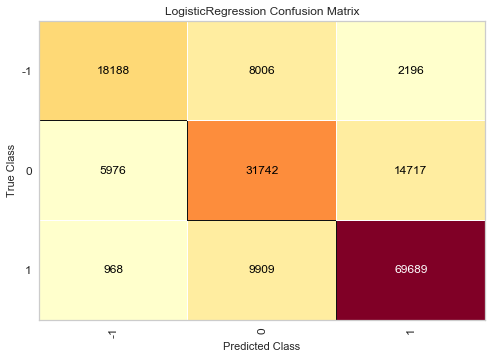

In [63]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(tfidf_vectors_train, y_train)
knn_cm.score(tfidf_vectors_test, y_test)

knn_cm.show()

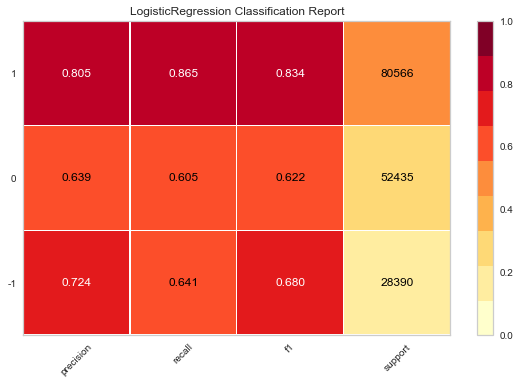

In [65]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(tfidf_vectors_train, y_train)        # Fit the visualizer and the model
visualizer.score(tfidf_vectors_test, y_test)        # Evaluate the model on the test data
visualizer.show()

#### SVD Tuning

In [66]:
from sklearn.linear_model import LogisticRegressionCV
svd_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 53)

In [67]:
model = svd_cv.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 29.5min finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 29.5min remaining:    0.0s


In [70]:
model.scores_

{-1: array([[0.50020137, 0.50935306, 0.65639968, 0.6951317 , 0.69829792,
         0.69876263, 0.69868828, 0.69868828],
        [0.50020447, 0.50991387, 0.65612491, 0.69538385, 0.69845096,
         0.69858727, 0.69868022, 0.69866782],
        [0.50019828, 0.50977756, 0.65622405, 0.69461553, 0.69712498,
         0.69730467, 0.69742859, 0.69743479],
        [0.50019828, 0.5093872 , 0.65904951, 0.69795526, 0.70068158,
         0.70143132, 0.70138175, 0.70138175]]),
 0: array([[0.50020137, 0.50935306, 0.65639968, 0.6951317 , 0.69829792,
         0.69876263, 0.69868828, 0.69868828],
        [0.50020447, 0.50991387, 0.65612491, 0.69538385, 0.69845096,
         0.69858727, 0.69868022, 0.69866782],
        [0.50019828, 0.50977756, 0.65622405, 0.69461553, 0.69712498,
         0.69730467, 0.69742859, 0.69743479],
        [0.50019828, 0.5093872 , 0.65904951, 0.69795526, 0.70068158,
         0.70143132, 0.70138175, 0.70138175]]),
 1: array([[0.50020137, 0.50935306, 0.65639968, 0.6951317 , 0.6982979

The best C = 1000.

In [71]:
#best C was 1000
svd_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=53, C=1000, penalty='l2', max_iter=500, n_jobs = -1)
model = svd_log_reg.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 19.2min finished


In [72]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(SVD_test)
# Probabilities for each class
base_probs = model.predict_proba(SVD_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.7001
       F-score:     0.6947
      Log Loss:     0.6700


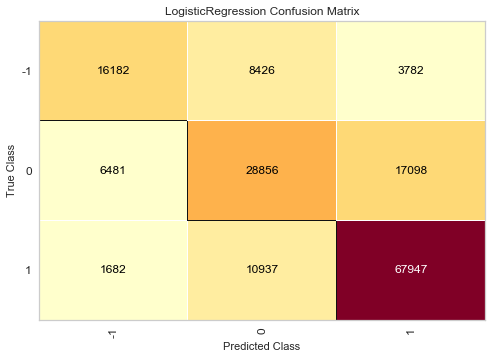

In [73]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(SVD_train, y_train)
knn_cm.score(SVD_test, y_test)

knn_cm.show()

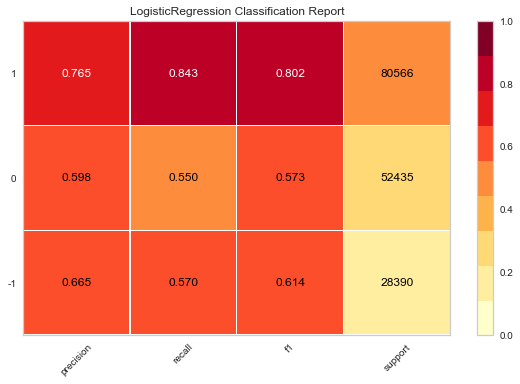

In [74]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(SVD_train, y_train)        # Fit the visualizer and the model
visualizer.score(SVD_test, y_test)        # Evaluate the model on the test data
visualizer.show()



## Doc2Vec with Simple Preprocess

In [18]:
#downloaded pretrained googlenews vectors https://bit.ly/GoogleNews-vectors-negative300 
#from gensim.models.keyedvectors import KeyedVectors
#word_vectors = KeyedVectors.load_word2vec_format('./pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [4]:
#importing necessary modules for Doc2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec  
from gensim.utils import simple_preprocess

### Preprocessing and Tokenizing Text

**Note: the text has not been preprocessed or split** 

In [ ]:
#preprocessing and tokenizing words
df.review_text = [simple_preprocess(text) for text in df.review_text]

In [21]:
df.review_text[0][0:20]

['fun',
 'fast',
 'paced',
 'science',
 'fiction',
 'thriller',
 'read',
 'it',
 'in',
 'nights',
 'and',
 'couldn',
 'put',
 'it',
 'down',
 'the',
 'book',
 'is',
 'about',
 'the']

In [ ]:
#pickling the results
with open("simple_preprocess.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.review_text), fp)

In [48]:
#unpickle the results
with open("simple_preprocess.txt", "rb") as fp:   # Unpickling
    review_text = np.array(pickle.load(fp))

review_text[0][0:20]

['fun',
 'fast',
 'paced',
 'science',
 'fiction',
 'thriller',
 'read',
 'it',
 'in',
 'nights',
 'and',
 'couldn',
 'put',
 'it',
 'down',
 'the',
 'book',
 'is',
 'about',
 'the']

In [22]:
#pickling the results
with open("rating.pkl", "wb") as fp:   #Pickling
    pickle.dump(list(df.rating), fp)

In [49]:
#unpickle the results
with open("rating.pkl", "rb") as fp:   # Unpickling
    rating = np.array(pickle.load(fp))

rating[0]

0

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review_text, rating, test_size=0.20, random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(645561,) (645561,)
(161391,) (161391,)


In [51]:
#clearing out memory before continuing
del(review_text, rating)

### Creating Corpus

In [10]:
#creating TaggedDocuments for the training corpus
training_corpus = np.empty(len(X_train), dtype=object)

for i, text in enumerate(X_train):
    tagged_doc = TaggedDocument(text, [i])
    training_corpus[i] = tagged_doc

In [11]:
training_corpus[0]

TaggedDocument(words=['not', 'sure', 'who', 'would', 'recommend', 'this', 'book', 'to', 'teens', 'or', 'adults', 'the', 'author', 'performs', 'such', 'an', 'amazing', 'feat', 'of', 'capturing', 'high', 'school', 'that', 'several', 'times', 'was', 'catapulted', 'back', 'into', 'my', 'own', 'school', 'crazy', 'trip', 'for', 'any', 'adult', 'when', 'teen', 'finishes', 'this', 'book', 'will', 'they', 'be', 'able', 'to', 'look', 'at', 'their', 'peers', 'differently', 'and', 'see', 'life', 'behind', 'appearances', 'or', 'does', 'that', 'take', 'time', 'and', 'experience', 'which', 'typically', 'comes', 'with', 'age', 'guess', 'either', 'way', 'it', 'doesn', 'matter', 'it', 'such', 'good', 'love', 'hate', 'book', 'll', 'recommend', 'it', 'to', 'anyone'], tags=[0])

In [13]:
#pickling the results
with open("training_corpus.pkl", "wb") as fp:   #Pickling
    pickle.dump(training_corpus, fp)

In [ ]:
#unpickle the results
with open("training_corpus.pkl", "rb") as fp:   # Unpickling
    training_corpus = pickle.load(fp)

In [20]:
training_corpus[196]

TaggedDocument(words=['https', 'wordpress', 'beware', 'of', 'spoilers', 'star', 'ratings', 'heroine', 'lainey', 'hero', 'brogan', 'plot', 'grovel', 'hero', 'apologises', 'cheating', 'none', 'hea', 'yes', 'triggers', 'none', 'average', 'score', 'best', 'line', 'anyone', 'who', 'got', 'in', 'the', 'way', 'of', 'girl', 'and', 'her', 'books', 'deserved', 'to', 'be', 'dumped', 'right', 'there', 'on', 'the', 'spot', 'worst', 'line', 'sorry', 'mom', 'failed', 'you', 'personal', 'review', 'this', 'was', 'good', 'old', 'school', 'office', 'romance', 'the', 'heroine', 'was', 'awkward', 'and', 'the', 'hero', 'was', 'the', 'typical', 'brooding', 'type', 'what', 'increased', 'the', 'rating', 'for', 'me', 'was', 'the', 'heroes', 'grovel', 'and', 'the', 'heroines', 'self', 'respect', 'random', 'ramblings', 'so', 'many', 'awkward', 'cringe', 'moments', 'don', 'have', 'much', 'patience', 'for', 'heroes', 'who', 'blow', 'hot', 'and', 'cold', 'loved', 'that', 'the', 'heroine', 'did', 'not', 'give', 'in',

### Doc2Vec - Distributed Memory (DM) Modeling (Simple Preprocess)

**DO NOT RERUN - CALC TIME**

In [25]:
#creating the model PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
model_dmm = Doc2Vec(dm=1, size=200, min_count=150, window = 4, workers=num_cores, epochs=12, 
                    alpha=0.05, negative = 3, comment='alpha=0.05')
#building vocab from training_corpus
model_dmm.build_vocab(training_corpus)

print(model_dmm.corpus_count)

645561


In [26]:
#training model
model_dmm.train(training_corpus, total_examples=model_dmm.corpus_count, epochs=model_dmm.epochs)

In [27]:
#removing training corpus from memory to speed things up
del(training_corpus)

In [28]:
#saving model to disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dmm")
model_dmm.save(fname)

In [6]:
#loading model from disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dmm")
model_dmm = Doc2Vec.load(fname)

In [29]:
#clearing parts of model from memory once training is finished
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [30]:
len(model_dmm.wv.vocab)

19476

### Vector Inference using Doc2Vec DM Model (Simple Preprocess)

In [31]:
#create model_dmm vector from the model for X_train
model_dmm_train = [model_dmm.infer_vector(text) for text in X_train]

In [32]:
del(X_train)

In [33]:
#create model_dmm vector from the model for X_test
model_dmm_test = [model_dmm.infer_vector(text) for text in X_test]

In [34]:
del(X_test)

In [35]:
type(model_dmm_train)

list

In [36]:
model_dmm_train[0][0:10]

array([-0.23266806, -0.40198934,  0.12266076,  0.01008816, -0.49503666,
       -0.402639  , -0.8527441 , -0.17340142,  0.36297685,  0.5966735 ],
      dtype=float32)

In [37]:
#pickling the model_dmm vector
with open("model_dmm_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_dmm_train, fp)

In [8]:
#unpickle the model_dmm vector
with open("model_dmm_train.pkl", "rb") as fp:   # Unpickling
    model_dmm_train = pickle.load(fp)

In [38]:
#pickling the model_dmm vector
with open("model_dmm_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_dmm_test, fp)

In [7]:
#unpickle the model_dmm vector
with open("model_dmm_test.pkl", "rb") as fp:   # Unpickling
    model_dmm_test = pickle.load(fp)

In [9]:
del(model_dmm)

### Logistic Regression - DMM (Simple Preprocess)

In [39]:
from sklearn.linear_model import LogisticRegressionCV
dmm_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 50)

In [40]:
dmm_logit_model = dmm_cv.fit(model_dmm_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.3min finished


In [41]:
dmm_logit_model.scores_

{-1: array([[0.63335006, 0.63750147, 0.6377741 , 0.63774932, 0.63779889,
         0.63781747, 0.63778649, 0.63781747],
        [0.63337258, 0.63850301, 0.63903588, 0.63907925, 0.63909164,
         0.63908545, 0.63909164, 0.63908545],
        [0.63240597, 0.63659458, 0.63718942, 0.63712746, 0.63713365,
         0.63714604, 0.63713365, 0.63714604],
        [0.63326724, 0.63811884, 0.63857736, 0.63848442, 0.63849681,
         0.63849681, 0.63850301, 0.63850301]]),
 0: array([[0.63335006, 0.63750147, 0.6377741 , 0.63774932, 0.63779889,
         0.63781747, 0.63778649, 0.63781747],
        [0.63337258, 0.63850301, 0.63903588, 0.63907925, 0.63909164,
         0.63908545, 0.63909164, 0.63908545],
        [0.63240597, 0.63659458, 0.63718942, 0.63712746, 0.63713365,
         0.63714604, 0.63713365, 0.63714604],
        [0.63326724, 0.63811884, 0.63857736, 0.63848442, 0.63849681,
         0.63849681, 0.63850301, 0.63850301]]),
 1: array([[0.63335006, 0.63750147, 0.6377741 , 0.63774932, 0.6377988

The best C was between 100 and 1000

In [42]:
#Using C = 200
from sklearn.linear_model import LogisticRegression
dmm_logit = LogisticRegression(verbose=1, solver='lbfgs', random_state=50, C=200, penalty='l2', max_iter=500, n_jobs = -1)
dmm_logit_model = dmm_logit.fit(model_dmm_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


In [43]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
dmm_preds = dmm_logit_model.predict(model_dmm_test)
# Probabilities for each class
dmm_probs = dmm_logit_model.predict_proba(model_dmm_test)[:,]

dmm_accuracy_score = accuracy_score(y_test, dmm_preds)
dmm_f1_value = f1_score(y_test, dmm_preds, average ='weighted')
dmm_log_loss_value = log_loss(y_test, dmm_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(dmm_accuracy_score))
print("       F-score:     {:0.4f}".format(dmm_f1_value))
print("      Log Loss:     {:0.4f}".format(dmm_log_loss_value))

Accuracy Score:     0.6376
       F-score:     0.6265
      Log Loss:     0.7797


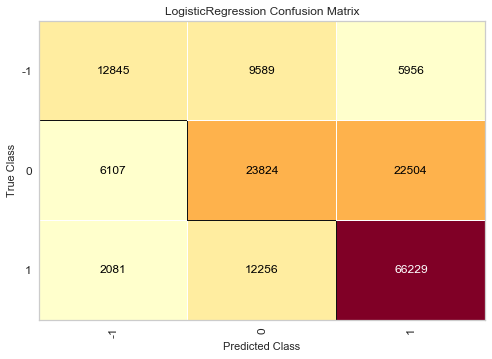

In [44]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(dmm_logit_model)

knn_cm.fit(model_dmm_train, y_train)
knn_cm.score(model_dmm_test, y_test)

knn_cm.show()

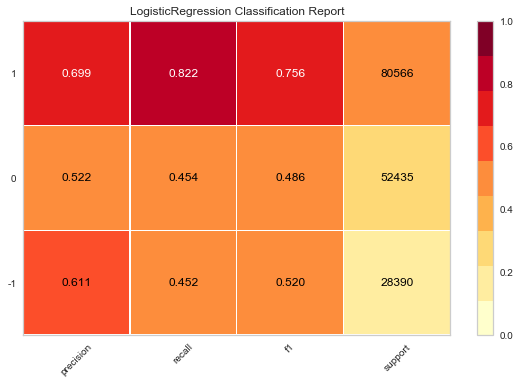

In [45]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(dmm_logit_model, support=True)

visualizer.fit(model_dmm_train, y_train)        # Fit the visualizer and the model
visualizer.score(model_dmm_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [46]:
#clearing memory
del(model_dmm_train, model_dmm_test)

### Doc2Vec - Distributed Bag of Words (DBOW) Modeling - Simple Preprocess

**DO NOT RERUN - CALC TIME**

In [2]:
#unpickle the results
with open("training_corpus.pkl", "rb") as fp:   # Unpickling
    training_corpus = pickle.load(fp)

In [11]:
#creating the model
model_dbow = Doc2Vec(dm=0, vector_size=200, negative=3, hs=0, min_count=150, sample = 0, workers=num_cores, epochs=12)
#vocab from other model
model_dbow.build_vocab(training_corpus)

print(model_dbow.corpus_count)

645561


In [12]:
#training model
model_dbow.train(training_corpus, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [13]:
#removing training corpus from memory to speed things up
del(training_corpus)

In [14]:
#saving model to disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dbow")
model_dbow.save(fname)

In [ ]:
#loading model from disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dbow")
model_dbow = Doc2Vec.load(fname)

In [15]:
#clearing parts of model from memory once training is finished
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [17]:
len(model_dbow.wv.vocab)

19476

### Vector Inference using Doc2Vec DBOW Model (Simple Preprocess)

In [ ]:
#create model_dbow vector from the model for X_train
model_dbow_train = [model_dbow.infer_vector(text) for text in X_train]

del(X_train)

In [23]:
#create model_dbow vector from the model for X_test
model_dbow_test = [model_dbow.infer_vector(text) for text in X_test]

del(X_test)

In [24]:
#pickling the model_dbow vector
with open("model_dbow_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_dbow_train, fp)

In [ ]:
#unpickle the model_dmm vector
with open("model_dbow_train.pkl", "rb") as fp:   # Unpickling
    model_dbow_train = pickle.load(fp)

In [25]:
#pickling the model_dmm vector
with open("model_dbow_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_dbow_test, fp)

In [ ]:
#unpickle the model_dmm vector
with open("model_dbow_test.pkl", "rb") as fp:   # Unpickling
    model_dbow_test = pickle.load(fp)

In [26]:
#clearing out memory before regression
del(model_dbow)

### Logistic Regression - DBOW (Simple Preprocess)

In [27]:
from sklearn.linear_model import LogisticRegressionCV
dbow_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 50)

In [28]:
#fitting logreg cv
dbow_logit_model = dbow_cv.fit(model_dbow_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min finished


In [29]:
#printing out scores
dbow_logit_model.scores_

{-1: array([[0.63678272, 0.67369308, 0.67539702, 0.67524831, 0.67527929,
         0.67527309, 0.6752607 , 0.67525451],
        [0.63779664, 0.67442221, 0.67618192, 0.67651651, 0.67655989,
         0.6765351 , 0.6765351 , 0.67652891],
        [0.63826135, 0.67396989, 0.6763678 , 0.67648553, 0.6765413 ,
         0.6765351 , 0.6765413 , 0.6765413 ],
        [0.63955016, 0.67522151, 0.67743974, 0.67742115, 0.67745833,
         0.67742735, 0.67744594, 0.67742735]]),
 0: array([[0.63678272, 0.67369308, 0.67539702, 0.67524831, 0.67527929,
         0.67527309, 0.6752607 , 0.67525451],
        [0.63779664, 0.67442221, 0.67618192, 0.67651651, 0.67655989,
         0.6765351 , 0.6765351 , 0.67652891],
        [0.63826135, 0.67396989, 0.6763678 , 0.67648553, 0.6765413 ,
         0.6765351 , 0.6765413 , 0.6765413 ],
        [0.63955016, 0.67522151, 0.67743974, 0.67742115, 0.67745833,
         0.67742735, 0.67744594, 0.67742735]]),
 1: array([[0.63678272, 0.67369308, 0.67539702, 0.67524831, 0.6752792

The best was C = 1.

In [32]:
#Using C = 1
from sklearn.linear_model import LogisticRegression
dbow_logit = LogisticRegression(verbose=1, solver='lbfgs', random_state=50, C=1, penalty='l2', max_iter=500, n_jobs = -1)
dbow_logit_model = dbow_logit.fit(model_dbow_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished


In [34]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
dbow_preds = dbow_logit_model.predict(model_dbow_test)
# Probabilities for each class
dbow_probs = dbow_logit_model.predict_proba(model_dbow_test)[:,]

dbow_accuracy_score = accuracy_score(y_test, dbow_preds)
dbow_f1_value = f1_score(y_test, dbow_preds, average ='weighted')
dbow_log_loss_value = log_loss(y_test, dbow_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(dbow_accuracy_score))
print("       F-score:     {:0.4f}".format(dbow_f1_value))
print("      Log Loss:     {:0.4f}".format(dbow_log_loss_value))

Accuracy Score:     0.6748
       F-score:     0.6693
      Log Loss:     0.7109


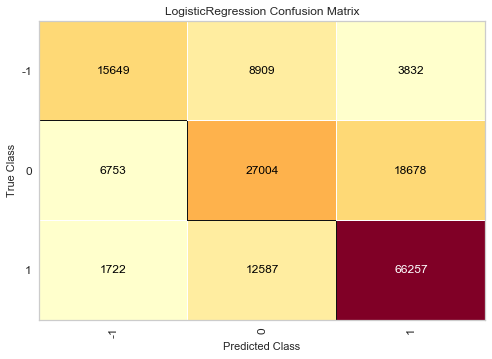

In [38]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(dbow_logit_model)

knn_cm.fit(model_dbow_train, y_train)
knn_cm.score(model_dbow_test, y_test)

knn_cm.show()

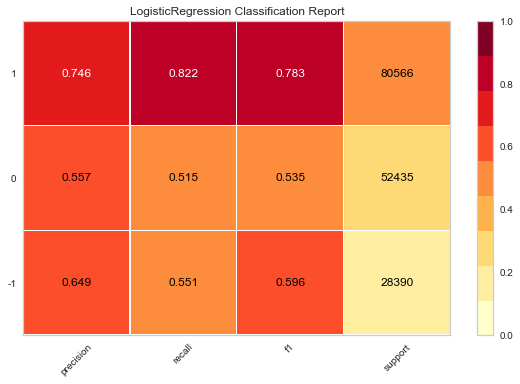

In [39]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(dbow_logit_model, support=True)

visualizer.fit(model_dbow_train, y_train)        # Fit the visualizer and the model
visualizer.score(model_dbow_test, y_test)        # Evaluate the model on the test data
visualizer.show()

#clearing memory
del(model_dbow_train, model_dbow_test)

### Concatenated Doc2Vec (Simple Preprocess)

In [40]:
#loading model from disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dmm")
model_dmm = Doc2Vec.load(fname)

In [45]:
#loading model from disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dbow")
model_dbow = Doc2Vec.load(fname)

In [46]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

model_concat = ConcatenatedDoc2Vec([model_dbow, model_dmm])

### Vector Inference using Doc2Vec Concat Model (Simple Preprocess)

In [52]:
#create model_dbow vector from the model for X_train
model_concat_train = [model_concat.infer_vector(text) for text in X_train]

del(X_train)

In [53]:
#create model_dbow vector from the model for X_train
model_concat_test = [model_concat.infer_vector(text) for text in X_test]

del(X_test)

In [54]:
#pickling the model_concat vector
with open("model_concat_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_concat_train, fp)

#pickling the model_dmm vector
with open("model_concat_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_concat_test, fp)

In [ ]:
#unpickle the model_dmm vector
with open("model_dbow_train.pkl", "rb") as fp:   # Unpickling
    model_dbow_train = pickle.load(fp)
    
#unpickle the model_dmm vector
with open("model_dbow_test.pkl", "rb") as fp:   # Unpickling
    model_dbow_test = pickle.load(fp)

In [55]:
#clearing out memory before regression
del(model_concat)

### Logistic Regression - Concat (Simple Preprocess)

In [56]:
from sklearn.linear_model import LogisticRegressionCV
concat_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', 
                                 solver='lbfgs', max_iter=500, cv = 4, n_jobs=-1, 
                                 verbose=1, random_state = 50)



In [57]:
#fitting logreg cv
concat_logit_model = concat_cv.fit(model_concat_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 14.8min finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 14.8min remaining:    0.0s


In [58]:
#printing out scores
concat_logit_model.scores_

{-1: array([[0.65724235, 0.67786308, 0.68097973, 0.68112844, 0.68097973,
         0.68098593, 0.68097973, 0.68097973],
        [0.65764298, 0.67793544, 0.68129996, 0.68136811, 0.68138051,
         0.68138051, 0.6813867 , 0.68138051],
        [0.65583989, 0.67603321, 0.67944111, 0.67954024, 0.67965797,
         0.67965797, 0.67965797, 0.67965797],
        [0.65766157, 0.67709895, 0.68080426, 0.68091579, 0.68085383,
         0.68083524, 0.68084764, 0.68083524]]),
 0: array([[0.65724235, 0.67786308, 0.68097973, 0.68112844, 0.68097973,
         0.68098593, 0.68097973, 0.68097973],
        [0.65764298, 0.67793544, 0.68129996, 0.68136811, 0.68138051,
         0.68138051, 0.6813867 , 0.68138051],
        [0.65583989, 0.67603321, 0.67944111, 0.67954024, 0.67965797,
         0.67965797, 0.67965797, 0.67965797],
        [0.65766157, 0.67709895, 0.68080426, 0.68091579, 0.68085383,
         0.68083524, 0.68084764, 0.68083524]]),
 1: array([[0.65724235, 0.67786308, 0.68097973, 0.68112844, 0.6809797

C = 100 is best.

In [59]:
#Using C = 100
from sklearn.linear_model import LogisticRegression
concat_logit = LogisticRegression(verbose=1, solver='lbfgs', random_state=50, C=100, penalty='l2', max_iter=500, n_jobs = -1)
concat_logit_model = concat_logit.fit(model_concat_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.6min finished


In [60]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
concat_preds = concat_logit_model.predict(model_concat_test)
# Probabilities for each class
concat_probs = concat_logit_model.predict_proba(model_concat_test)[:,]

concat_accuracy_score = accuracy_score(y_test, concat_preds)
concat_f1_value = f1_score(y_test, concat_preds, average ='weighted')
concat_log_loss_value = log_loss(y_test, concat_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(concat_accuracy_score))
print("       F-score:     {:0.4f}".format(concat_f1_value))
print("      Log Loss:     {:0.4f}".format(concat_log_loss_value))

Accuracy Score:     0.6789
       F-score:     0.6736
      Log Loss:     0.7025


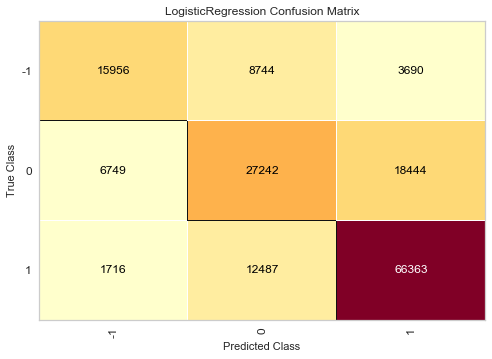

In [61]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(concat_logit_model)

knn_cm.fit(model_concat_train, y_train)
knn_cm.score(model_concat_test, y_test)

knn_cm.show()

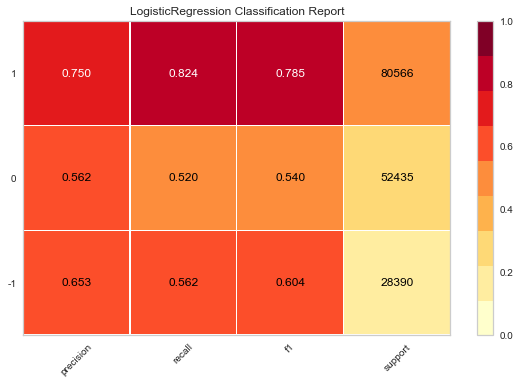

In [62]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(concat_logit_model, support=True)

visualizer.fit(model_concat_train, y_train)        # Fit the visualizer and the model
visualizer.score(model_concat_test, y_test)        # Evaluate the model on the test data
visualizer.show()

#clearing memory
del(model_concat_train, model_concat_test)

## Doc2Vec with more preprocessing

In [4]:
import multiprocessing
num_cores = multiprocessing.cpu_count()

#importing necessary modules for Doc2Vec
import re
import numpy as np
import pickle
from gensim.models.doc2vec import TaggedDocument, Doc2Vec  

In [6]:
#unpickle the preprocessed text (loading from file)
with open("preprocessed_text.txt", "rb") as fp:   # Unpickling
    review_text = pickle.load(fp)

In [7]:
#breaking out words to list for doc2vec
review_text = np.array([text.split() for text in review_text])

review_text[0][:20]

['fun',
 'fast',
 'pace',
 'scienc',
 'fiction',
 'thriller',
 '_pron_',
 'read',
 '_pron_',
 'two',
 'night',
 'and',
 'couldnt',
 'put',
 '_pron_',
 'down',
 'book',
 'be',
 'quantum',
 'theori']

In [9]:
#the preprocessed text list (loading from file)
with open("preprocessed_text_list.txt", "wb") as fp:   # pickling
    pickle.dump(review_text, fp)

In [10]:
#unpickle the ratings
with open("rating.pkl", "rb") as fp:   # Unpickling
    rating = np.array(pickle.load(fp))

rating[0]

0

In [11]:
#splitting data prior to creating corpus

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review_text, rating, test_size=0.20, random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(645561,) (645561,)
(161391,) (161391,)


In [12]:
#clearing out memory
del(review_text, rating)

### Creating Corpus (more preprocessing)

In [13]:
#creating TaggedDocuments for the training corpus
training_corpus_processed = np.empty(len(X_train), dtype=object)

for i, text in enumerate(X_train):
    tagged_doc = TaggedDocument(text, [i])
    training_corpus_processed[i] = tagged_doc

training_corpus_processed[0]

TaggedDocument(words=['im', 'not', 'sure', 'who', '_pron_', 'would', 'recommend', 'book', 'teen', 'or', 'adult', 'author', 'perform', 'amaz', 'feat', 'captur', 'high', 'school', 'sever', 'time', '_pron_', 'be', 'catapult', 'back', 'into', 'my', 'own', 'school', 'crazi', 'trip', 'ani', 'adult', 'when', 'teen', 'finish', 'book', 'will', '_pron_', 'be', 'abl', 'look', 'their', 'peer', 'differ', 'and', 'see', 'life', 'behind', 'appear', 'or', 'do', 'take', 'time', 'and', 'experi', 'which', 'typic', 'come', 'with', 'age', '_pron_', 'guess', 'either', 'way', '_pron_', 'doesnt', 'matter', 'it', 'good', 'loveh', 'book', 'ill', 'recommend', '_pron_', 'anyon'], tags=[0])

In [15]:
#pickling the results
with open("training_corpus_processed.pkl", "wb") as fp:   #Pickling
    pickle.dump(training_corpus_processed, fp)

In [ ]:
#unpickle the results
with open("training_corpus_processed.pkl", "rb") as fp:   # Unpickling
    training_corpus_processed = pickle.load(fp)

training_corpus_processed[196]

### Doc2Vec - Distributed Bag of Words - DBOW (More preprocessing)

**DO NOT RERUN - CALC TIME**

In [16]:
#creating the model
model_dbow_processed = Doc2Vec(dm=0, vector_size=200, negative=3, hs=0, min_count=150, sample = 0, workers=num_cores, epochs=12)
#vocab from other model
model_dbow_processed.build_vocab(training_corpus_processed)

print(model_dbow_processed.corpus_count)

645561


In [17]:
#training model
model_dbow_processed.train(training_corpus_processed, total_examples=model_dbow_processed.corpus_count, 
                 epochs=model_dbow_processed.epochs)

#removing training corpus from memory to speed things up
del(training_corpus_processed)

In [18]:
#saving model to disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dbow_processed")
model_dbow_processed.save(fname)

In [ ]:
#loading model from disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("model_dbow_processed")
model_dbow_processed = Doc2Vec.load(fname)

In [19]:
#clearing parts of model from memory once training is finished
model_dbow_processed.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

len(model_dbow_processed.wv.vocab)

14221

### Vector Inference using Doc2Vec DBOW Model (more preprocess)

In [20]:
#create model_dbow vector from the model for X_train
model_dbow_train_processed = [model_dbow_processed.infer_vector(text) for text in X_train]

del(X_train)

In [22]:
#create model_dbow vector from the model for X_test
model_dbow_test_processed = [model_dbow_processed.infer_vector(text) for text in X_test]

del(X_test)

In [23]:
#pickling the model_dbow vector
with open("model_dbow_train_processed.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_dbow_train_processed, fp)

#pickling the model_dmm vector
with open("model_dbow_test_processed.pkl", "wb") as fp:   #Pickling
    pickle.dump(model_dbow_test_processed, fp)

In [ ]:
#unpickle the model_dmm vector
with open("model_dbow_train_processed.pkl", "rb") as fp:   # Unpickling
    model_dbow_train_processed = pickle.load(fp)
    
#unpickle the model_dmm vector
with open("model_dbow_test_processed.pkl", "rb") as fp:   # Unpickling
    model_dbow_test_processed = pickle.load(fp)

In [25]:
#clearing out memory before regression
del(model_dbow_processed)

### Logistic Regression - DBOW (Simple Preprocess)

In [28]:
from sklearn.linear_model import LogisticRegressionCV
dbow_cv_processed = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', 
                                 solver='lbfgs', max_iter=500, cv = 4, n_jobs=-1, 
                                 verbose=1, random_state = 50)

In [29]:
#fitting logreg cv
concat_dbow_model_processed = concat_cv_processed.fit(model_dbow_train_processed, y_train)

#printing out scores
concat_dbow_model_processed.scores_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s


{-1: array([[0.63330049, 0.67118984, 0.67377983, 0.67387277, 0.67383559,
         0.67386657, 0.67386038, 0.67386038],
        [0.6322077 , 0.67128694, 0.67355474, 0.67359192, 0.67359812,
         0.67361051, 0.67359812, 0.67361051],
        [0.63278394, 0.67116302, 0.67359812, 0.67364149, 0.6736291 ,
         0.67361051, 0.67363529, 0.67363529],
        [0.63287069, 0.67303426, 0.67396369, 0.67415577, 0.67407522,
         0.67406903, 0.67406283, 0.67406283]]),
 0: array([[0.63330049, 0.67118984, 0.67377983, 0.67387277, 0.67383559,
         0.67386657, 0.67386038, 0.67386038],
        [0.6322077 , 0.67128694, 0.67355474, 0.67359192, 0.67359812,
         0.67361051, 0.67359812, 0.67361051],
        [0.63278394, 0.67116302, 0.67359812, 0.67364149, 0.6736291 ,
         0.67361051, 0.67363529, 0.67363529],
        [0.63287069, 0.67303426, 0.67396369, 0.67415577, 0.67407522,
         0.67406903, 0.67406283, 0.67406283]]),
 1: array([[0.63330049, 0.67118984, 0.67377983, 0.67387277, 0.6738355

In [33]:
#Using C = 10
from sklearn.linear_model import LogisticRegression
dbow_logit_processed = LogisticRegression(verbose=1, solver='lbfgs', random_state=50, 
                                             C=10, penalty='l2', max_iter=500, n_jobs = -1)
dbow_logit_model_processed = dbow_logit_processed.fit(model_dbow_train_processed, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


In [34]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
dbow_preds_processed = dbow_logit_model_processed.predict(model_dbow_test_processed)
# Probabilities for each class
dbow_probs_processed = dbow_logit_model_processed.predict_proba(model_dbow_test_processed)[:,]

dbow_accuracy_score_processed = accuracy_score(y_test, dbow_preds_processed)
dbow_f1_value_processed = f1_score(y_test, dbow_preds_processed, average ='weighted')
dbow_log_loss_value_processed = log_loss(y_test, dbow_probs_processed, normalize=True)
print("Accuracy Score:     {:0.4f}".format(dbow_accuracy_score_processed))
print("       F-score:     {:0.4f}".format(dbow_f1_value_processed))
print("      Log Loss:     {:0.4f}".format(dbow_log_loss_value_processed))

Accuracy Score:     0.6720
       F-score:     0.6663
      Log Loss:     0.7165


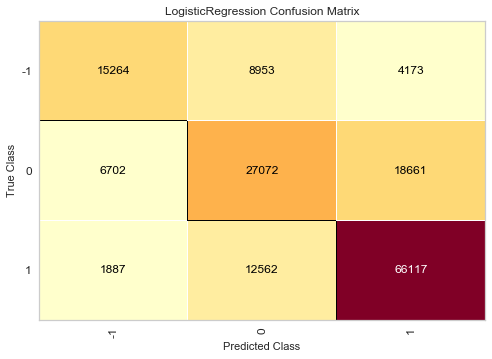

In [42]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(dbow_logit_model_processed)

knn_cm.fit(model_dbow_train_processed, y_train)
knn_cm.score(model_dbow_test_processed, y_test)

knn_cm.show()


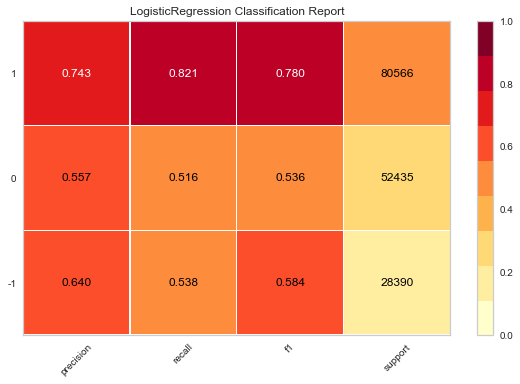

In [43]:

from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(dbow_logit_model_processed, support=True)

visualizer.fit(model_dbow_train_processed, y_train)        # Fit the visualizer and the model
visualizer.score(model_dbow_test_processed, y_test)        # Evaluate the model on the test data
visualizer.show()

#clearing memory
del(model_dbow_train_processed, model_dbow_test_processed)